# Exercise 302

The goal is to find the best set of hyperparameters which maximize the generalization performance on training set.

Here again we limit the size of the training set to make computation run faster.

In [1]:
import numpy as np
import pandas as pd

import warnings
# We do this to ignore several specific warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/adult-census.csv')
target = df['class']
data = df.drop(columns=['class', 'fnlwgt', 'education-num'])

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data_train, data_test, target_train, target_test = train_test_split(data, target,
                                                                   train_size=.2,
                                                                   random_state=42)

In this exercise, we will progressively define the classification pipeline and later tune its hyperparameters.

Our pipeline, should:  

* preprocess the categorical columns using a `OneHotEncoder` and use a `StandardScaler` to normalize the numerical data.
* use a `LogisticRegression` as a predictive model.

We start by defining the columns and the preprocessing pipelines to be applied on each group of columns.

In [5]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include='object')
categorical_columns = categorical_columns_selector(data)

numerical_columns_selector = selector(dtype_exclude='object')
numerical_columns = numerical_columns_selector(data)

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_processor = OneHotEncoder(handle_unknown='ignore')
numerical_processor = StandardScaler()

Now, we create a `ColumnTransformer` to redirect the specific columns  a preprocessing pipeline.

In [7]:
from sklearn.compose import ColumnTransformer

In [8]:
preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_processor, categorical_columns),
    ('num-preprocessor', numerical_processor, numerical_columns)
])

Now we go ahead and assemble the final pipeline by combining the above preprocessor with a logistic regression classifier.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [10]:
model = make_pipeline(preprocessor, LogisticRegression())

Use `RandomizedSearchCV` with `n_iter=20` to find the best set of hyperparameters by tuning the following parameters of the model:

* the parameter `C` of the `LogisticRegression` with values ranging from .001 to 10. We can use a log-uniform distribution (`scipy.stats.loguniform`)
* the parameter `with_mean` of the `StandardScaler` with possible values `True` or `False`;
* the parameter `with_std` of the `StandardScaler` with possible values `True` or `False`.

Once the computation has completed, print the best combination of parameters stored int the `best_params_` attribute

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [12]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__cat-preprocessor', 'columntransformer__num-preprocessor', 'columntransformer__cat-preprocessor__categories', 'columntransformer__cat-preprocessor__drop', 'columntransformer__cat-preprocessor__dtype', 'columntransformer__cat-preprocessor__handle_unknown', 'columntransformer__cat-preprocessor__sparse', 'columntransformer__num-preprocessor__copy', 'columntransformer__num-preprocessor__with_mean', 'columntransformer__num-preprocessor__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticreg

In [13]:
param_distributions = {
    "logisticregression__C": loguniform(0.001, 10),
    "columntransformer__num-preprocessor__with_mean": [True, False],
    "columntransformer__num-preprocessor__with_std": [True, False],
}

In [14]:
model_random_search = RandomizedSearchCV(model,
                                        param_distributions,
                                        n_iter=20,
                                        error_score=np.nan,
                                        n_jobs=2,
                                        verbose=1,
                                        random_state=1)

In [15]:
model_random_search.fit(data_train, target_train)
model_random_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/athena/opt/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/athena/opt/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

{'columntransformer__num-preprocessor__with_mean': False,
 'columntransformer__num-preprocessor__with_std': True,
 'logisticregression__C': 0.4806954824961597}

So the best hyperparameters give a model where the features are scaled but not centered and the final model is regularized.

Getting the best parameter combinations is the main outcome of the hyper-parameter optimization procedure. However it is also interesting to assess the sensitivity of the best models to the choice of those parameters.

In practice, a randomized hyperparameter search is usually run with a large number of iterations. In order to avoid the computation cost and still make a decent analysis, we load the results obtained from a similar search with 200 iterations.

In [16]:
cv_results = pd.read_csv('data/randomized_search_results_logistic_regression.csv')

To simplify the axis of the plot, we will rename the column of the dataframe and only select the mean test score and the value of the hyperparameters.

In [17]:
column_name_mapping = {
    "param_logisticregression__C": "C",
    "param_columntransformer__num-preprocessor__with_mean": "centering",
    "param_columntransformer__num-preprocessor__with_std": "scaling",
    "mean_test_score": "mean test accuracy",
}

cv_results = cv_results.rename(columns=column_name_mapping)
cv_results = cv_results[column_name_mapping.values()].sort_values(
    "mean test accuracy", ascending=False)

In addition, the parallel coordinate plot from `plotly` expects all data to be numeric. Thus, we convert the boolean indicator informing whether or not the data were centered or scaled into an integer, where true is 1 an false is 0.

We also take the logarithm of the `C` values to span the data on a broader range for a better visualization.

In [18]:
column_scaler = ["centering", "scaling"]
cv_results[column_scaler] = cv_results[column_scaler].astype(np.int64)
cv_results['log C'] = np.log10(cv_results['C'])

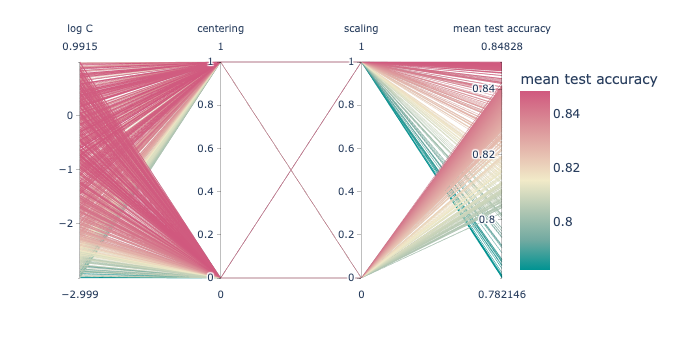

In [21]:
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results,
    color="mean test accuracy",
    dimensions=["log C", "centering", "scaling", "mean test accuracy"],
    color_continuous_scale=px.colors.diverging.Tealrose,
)
fig.show()

It is possible to select a range of results by clicking and holding on any axis of the above parallel coordinate plot. You can also slide the range selection and cross two selections to see the intersections.

Selecting the best performing models (i.e. above an accuracy of 84.5%), we observe the following pattern:

* scaling the data is important. All the best performing models are scaling the data;
* centering the data does not have a strong impact on the performance;
* using some regularization is fine but using too much is a problem. Recall that a smaller value of `C` means a stronger regularization. In particular no pipeline with `C` lower than .001 can be found among the best models.